In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from exfor_tools import (
    AngularDistribution,
    ExforEntryAngularDistribution,
    categorize_measurements_by_energy,
    filter_out_lab_angle,
    get_exfor_differential_data,
    init_exfor_db,
    plot_angular_distributions,
)

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


## Demonstration of data retrieval and plotting for various reactions and quantities

In [3]:
ca48_pp = ExforEntryAngularDistribution(
    entry="C0624",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dA",
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)

Found subentry C0624005 with the following columns:
['EN-ERR', 'ERR-SYS', 'ERR-7', 'ERR-9', 'EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


In [4]:
ca48_nn = ExforEntryAngularDistribution(
    entry="14303",
    target=(48, 20),
    projectile=(1, 0),
    quantity="dXS/dA",
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)

Found subentry 14303004 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry 14303005 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


In [5]:
label_settings = {
    "label_xloc_deg": None,
    "label_offset_factor": 0.1,
    "label_energy_err": False,
    "label_offset": True,
    "label_incident_energy": True,
    "label_excitation_energy": False,
    "label_exfor": False,
}

(0.0001, 1000000000.0)

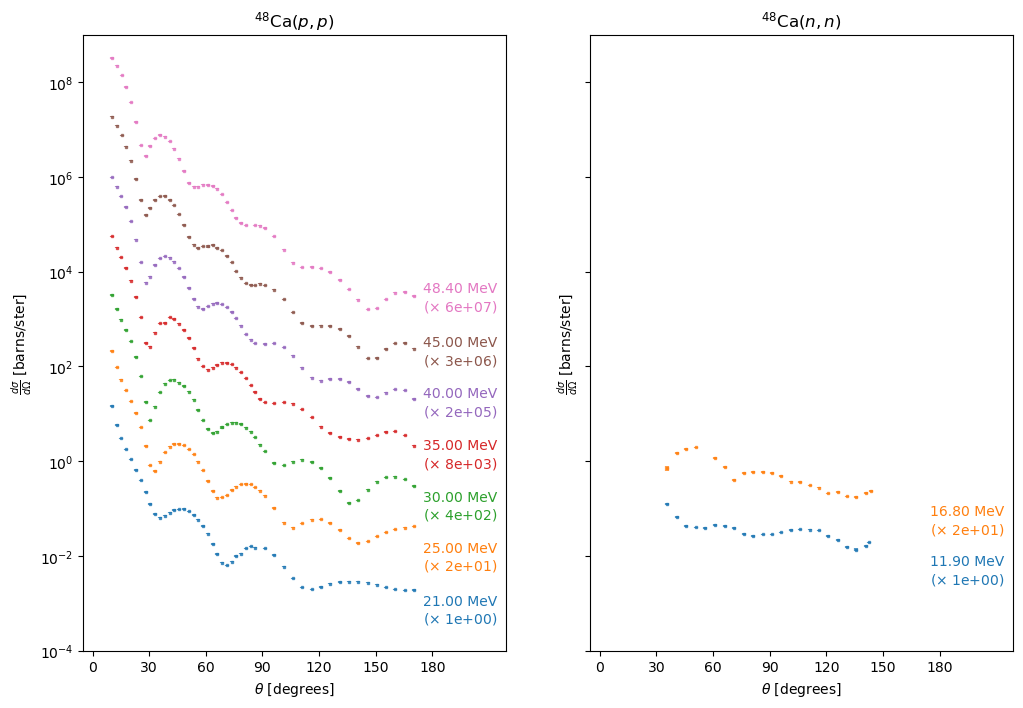

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
ca48_pp.plot(
    ax1,
    offsets=20,
    label_kwargs=label_settings,
)
ca48_nn.plot(
    ax2,
    offsets=20,
    label_kwargs=label_settings,
)
ax1.set_xlim([-5, 219])
ax2.set_xlim([-5, 219])
ax1.set_ylim([1e-4, 1e9])

In [7]:
ca48_pp_ana = ExforEntryAngularDistribution(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="Ay",
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)

Found subentry O0239015 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239017 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239019 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']


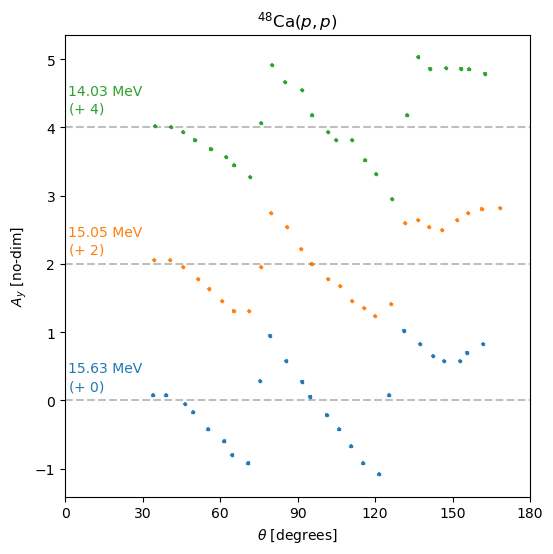

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

ca48_pp_ana.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

In [9]:
ca48_pp_ruth = ExforEntryAngularDistribution(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dRuth",
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)

Found subentry O0239014 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239016 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239018 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']


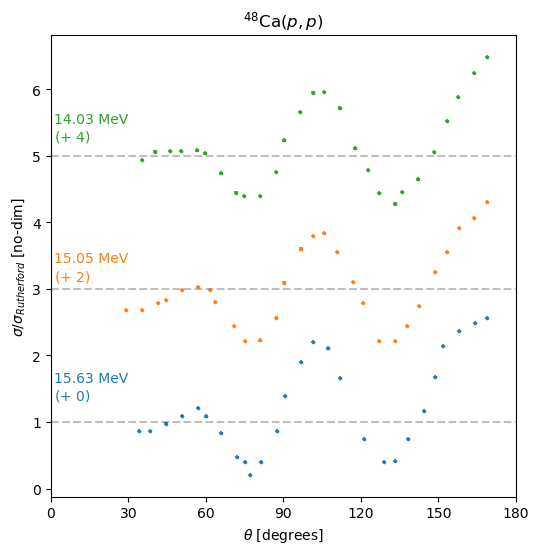

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

ca48_pp_ruth.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    baseline_offset=1,
    label_kwargs={
        "label_xloc_deg": 1,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

## Querying for multiple entries
Let's figure out how to query EXFOR for multiple entries and plot them all

In [11]:
all_entries_lead208_pp = get_exfor_differential_data(
    target=(208, 82),
    projectile=(1, 1),
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)
print(f"Found {len(all_entries_lead208_pp.keys())} entries")

Found subentry C0893042 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'ERR-S']
Found subentry C1019034 with the following columns:
['ERR-S', 'EN', 'ANG-CM', 'DATA-CM']
Found subentry E1201014 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry E1846023 with the following columns:
['EN-RSL', 'E-RSL', 'E-LVL-ERR', 'EN', 'ANG-CM', 'DATA-CM']
Found subentry O0032025 with the following columns:
['EN', 'ANG-CM', 'DATA', 'ERR-S']
Found subentry O0142011 with the following columns:
['EN', 'ERR-1', 'ANG-CM', 'DATA-CM', 'ERR-T']
Found subentry O0157004 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0166023 with the following columns:
['EN', 'ANG-ERR-D', 'ERR-DIG', 'ANG-CM', 'DATA']
Found subentry O0208009 with the following columns:
['EN', 'EN-RSL-FW', 'EN-RSL', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry O0211017 with the following columns:
['EN', 'EN-RSL', 'ANG-CM', 'DATA', 'ERR-T']
Found subentry O022

Now, let's plot measurements from all of those entries on the same figure

In [12]:
measurements_categorized = categorize_measurements_by_energy(
    all_entries_lead208_pp, Einc_fudge_factor=0.5
)

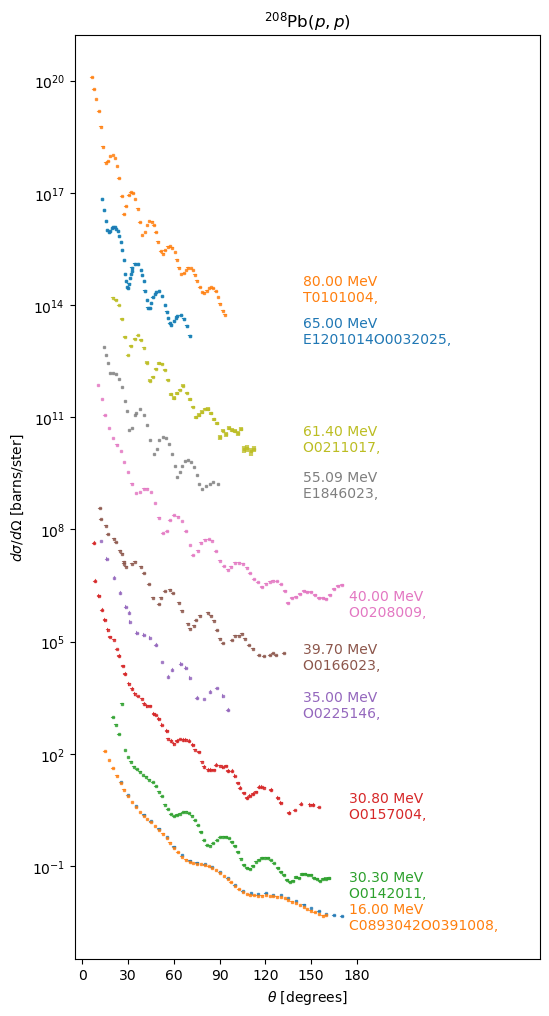

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
plot_angular_distributions(
    measurements_categorized,
    ax,
    offsets=100,
    data_symbol=r"$d\sigma/d\Omega$",
    rxn_label=list(all_entries_lead208_pp.values())[0].rxn,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": False,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": True,
    },
)
ax.set_xlim([-5, 300])

plt.savefig("lead_208_pp_dxds.pdf")

## Some things to notice:
- EXFOR subentries E1201014 and O0032025 are duplicates
- EXFOR subentry [O0142011](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=123189&&sub=O0142&plus=1) has an outlier (the 4th point). Looking at the data, it is exactly 10 times what it would be expected. It is likely this is the result of transcription error.

In [14]:
all_entries_lead208_nn = get_exfor_differential_data(
    target=(208, 82),
    projectile=(1, 0),
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)

Found subentry 10871002 with the following columns:
['EN', 'EN-RSL', 'ANG-CM', 'DATA-CM', 'ERR-T']
Found subentry 12701005 with the following columns:
['DATA-ERR2', 'EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR1']
Found subentry 12865002 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry 13685002 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry 13946004 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'ERR-S', 'ERR-SYS']
Found subentry 14317002 with the following columns:
['ERR-1', 'ERR-2', 'EN', 'ANG-CM', 'DATA-CM', 'ERR-T']
Found subentry 14317003 with the following columns:
['ERR-1', 'ERR-2', 'EN', 'ANG-CM', 'DATA-CM', 'ERR-T']


NotImplementedError: Subentry 22847003 has an ambiguous set of error labels:
ERR-T
ERR-S


In [ ]:
measurements_categorized = categorize_measurements_by_energy(
    all_entries_lead208_pp, Einc_fudge_factor=0.5
)

In [ ]:
## TODO print out all subentries and their column labels first, flagging any which have weird errors
## return list of flagged entries
## construct an entry object for each flagged entry one by one which